# One shot learning using triplet loss

The main idea of this project is to experiment with keras and the omniglot dataset to build a *"One shot learning"* model.

These kind of models solves categorization problem by seeing only a few exemples of each catgories.

The dataset used is the *omniglot* dataset. It contains 4840 handwritten letters from differents alphabet with 20 examples for each letters. You can find the dataset here: https://github.com/brendenlake/omniglot

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import random
from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity, pairwise_distances

from keras import applications
from keras import callbacks
from keras import layers
from keras.models import Sequential, Model
from keras import backend as K
from keras.utils import Sequence
from keras.optimizers import Adam
from keras.regularizers import l2

%matplotlib inline 

/home/jfink/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# The triplet loss approach

To learn more about the triplet loss you can read this : https://towardsdatascience.com/siamese-network-triplet-loss-b4ca82c1aec8

Here is the article talking about the triplet loss function used in my example : https://towardsdatascience.com/lossless-triplet-loss-7e932f990b24

In [2]:
# Triplet loss functions

def triplet_loss(y_true, y_pred, N = 126, beta = 126, epsilon=1e-8):
    """
    Implementation of the triplet loss function
    
    Arguments:
    y_true -- true labels, required when you define a loss in Keras, you don't need it in this function.
    y_pred -- python list containing three objects:
            anchor -- the encodings for the anchor data
            positive -- the encodings for the positive data (similar to anchor)
            negative -- the encodings for the negative data (different from anchor)
    N  --  The number of dimension 
    beta -- The scaling factor, N is recommended
    epsilon -- The Epsilon value to prevent ln(0)
    
    
    Returns:
    loss -- real number, value of the loss
    """
    anchor = tf.convert_to_tensor(y_pred[:,0:N])
    positive = tf.convert_to_tensor(y_pred[:,N:N*2]) 
    negative = tf.convert_to_tensor(y_pred[:,N*2:N*3])
    
    # distance between the anchor and the positive
    pos_dist = tf.reduce_sum(tf.square(tf.subtract(anchor,positive)),1)
    # distance between the anchor and the negative
    neg_dist = tf.reduce_sum(tf.square(tf.subtract(anchor,negative)),1)
    
    #Non Linear Values  
    
    # -ln(-x/N+1)
    pos_dist = -tf.log(-tf.divide((pos_dist),beta)+1+epsilon)
    neg_dist = -tf.log(-tf.divide((N-neg_dist),beta)+1+epsilon)
    
    # compute loss
    loss = neg_dist + pos_dist
    
    return loss


# The Network

The "encoding" network is a classical CNN. Once trained he will map the images in a latent space where all the similar letters will be clusterised.

For the structure of the training model I send you again to this article : https://towardsdatascience.com/siamese-network-triplet-loss-b4ca82c1aec8

In [3]:

def get_embedding_network(input_shape):
    
    model = Sequential()
    model.add(layers.Conv2D(32, kernel_size=(3,3),
                    activation='relu',
                    input_shape=input_shape))

    model.add(layers.Conv2D(64, (3,3), activation='relu'))
    model.add(layers.MaxPooling2D(pool_size=2))
    model.add(layers.Dropout(0.25))
    model.add(layers.Flatten())
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(126, activation='sigmoid'))

    return model



def get_training_model(input_shape):
    
    anchor_input = layers.Input(shape=input_shape)
    positive_input = layers.Input(shape=input_shape)
    negative_input = layers.Input(shape=input_shape)

    embedding_net = get_embedding_network(input_shape)

    anchor_embedding = embedding_net(anchor_input)
    positive_embedding = embedding_net(positive_input)
    negative_embedding = embedding_net(negative_input)

    merged = layers.concatenate([anchor_embedding, positive_embedding, negative_embedding], axis=-1)

    model = Model(inputs=[anchor_input, positive_input, negative_input], outputs=merged)

    return model





# Loading the omniglot dataset

The boring stuff 

In [4]:
# Loading dataset function utils

def load_dataframe(languages):
    """
        This function take an array of language name and
        index all the symbol of each language in a dataframe
        with column : id, path
    """
    
    sign_id = []
    sign_path = []
    
    for language in languages:
        ids, paths = scan_directory(language)
        
        sign_id += ids
        sign_path += paths
        
    file = [('id', sign_id),
             ('path', sign_path),
           ]
    
    return pd.DataFrame.from_items(file)


def scan_directory(directory_name):
    path = Path("./omniglot/{}".format(directory_name))
    
    sign_id = []
    sign_path = []
    
    for elem in path.iterdir():
        if elem.is_dir():
            ids, paths = process_char(elem)
            
            sign_id += ids
            sign_path += paths
            
    return sign_id, sign_path
            

def process_char(char_path):
    
    sign_id = []
    file_path = []
    
    for elem in char_path.iterdir():
        if elem.is_dir():
            continue
            
        # Processing the file
        path_str = str(elem)
        
        file_name = path_str.split("/")[-1]
        img_id = file_name.split("_")[0]
        
        sign_id.append(img_id)
        file_path.append(path_str)
    
    return sign_id, file_path


def load_image(image_path):
    pic = Image.open(image_path)
    img = np.true_divide(np.array(pic), 255)
    return img[:, :, np.newaxis]
    

# Split test and train

I decided to train my model on the letter from 6 alphabets and to test it on 2 other alphabet. Therefore I'm sure that my model has never saw the test letters before.

train len 3660
test len : 1180


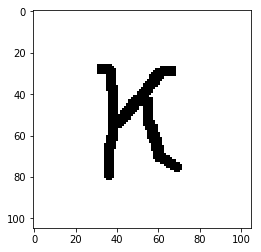

In [5]:

train_languages = ["Balinese", "Early_Aramaic", "Greek", "Japanese_(katakana)", "Korean", "Latin"]
test_languages = ["Sanskrit", "Tagalog"]

# Loading train and data and printing
train_set = load_dataframe(train_languages)
test_set = load_dataframe(test_languages)

path = train_set["path"].iloc[1234]

TEST_IMG = load_image(path)
disp_img = TEST_IMG.reshape(TEST_IMG.shape[:2])
plt.imshow(disp_img, cmap="gray")

print("train len {}".format(len(train_set)))
print("test len : {}".format(len(test_set)))


# Triplet Generator

In order to feed our model with images and to avoid to explode our memory we are going to generate images on the fly (https://keras.io/utils/#sequence)

This generator will compose random triplet when asked for

In [6]:

class TripletGenerator(Sequence):
    
    def __init__(self, batch_size, nbr_triplet, data):
        
        self.data = data
        self.nbr_triplet = nbr_triplet
        self.batch_size = batch_size
        
        
    def __len__(self):
        return np.ceil(self.nbr_triplet / self.batch_size).astype(np.int64)
    
    
    def __getitem__(self, idx):
        # generate random triplet
        
        anchors = []
        negs = []
        pos = []
        
        selected_char = self.data.sample(n=self.batch_size)
        
        
        for index, row in selected_char.iterrows():
            
            anchors.append(load_image(row["path"]))
            
            negs.append(self.get_neg(row["id"]))
            pos.append(self.get_pos(row["id"], row["path"]))
            
        X = [np.array(anchors), np.array(pos), np.array(negs)]
        y = np.ones(len(anchors))
        
        return X, y
    
    def get_pos(self, id, path):
        same = self.data[self.data["id"] == id]
        same = same[same["path"] != path]
        sel = same.sample(n=1)
        return load_image(sel["path"].iloc[0])
        
        
    def get_neg(self, id):
        diff = self.data[self.data["id"] != id]
        sel = diff.sample(n=1)
        return load_image(sel["path"].iloc[0])
            


# Training the triplet loss model

The training is made on 100 epoch with a batch size of 1000 triplets and 10 000 triplets generated per epoch.

Due to CPU restriction, I wasn't able to run it for much longer but we can see that the loss slowly decrease during the 100 epoch. 

(And due to my stupidity, I erased the result so I will rerun this cell one day to show you the drop)

In [ ]:
train_model = get_training_model(TEST_IMG.shape)
train_model.compile(loss=triplet_loss, optimizer=Adam())

train_model.summary()

gen_train = TripletGenerator(10, 100, train_set)

train_model.fit_generator(generator=gen_train, verbose=1, use_multiprocessing=True, epochs=10)

Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 105, 105, 1)  0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 105, 105, 1)  0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            (None, 105, 105, 1)  0                                            
__________________________________________________________________________________________________
sequential_1 (Sequential)       (None, 126)          20515198 

# Test embeddings TSNE

We are going to map 10 char in the latent space to see if they are far from each other in the latent space.

We can clearly see some clusters but 100 epoch don't seem to be enough to have nice clusters for each letters.

In [18]:

# Extracting embedding model

seq_input = train_model.layers[3].get_input_at(-1)

encoder = Model(inputs = seq_input,
                outputs=train_model.layers[3].get_output_at(-1))



# Selecting 10 test char
sample = random.sample(test_set["id"].tolist(), 10)

X = []
label = []

for id_img in sample:
    
    cur_df = test_set[test_set["id"] == id_img]
    
    for index, row in cur_df.head(10).iterrows():

        img = load_image(row["path"])
 
        embed = encoder.predict(np.array([np.array(img)]))
        
        X.append(embed)
        label.append(id_img)


X = np.array(X)
label = np.array(label)

10


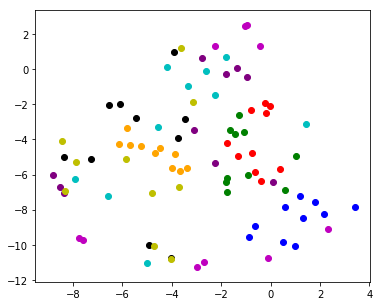

In [19]:
from sklearn.manifold import TSNE

nsamples, nx, ny = X.shape
X = X.reshape((nsamples,nx*ny))

tsne = TSNE(n_components=2)
X_2d = tsne.fit_transform(X)

target_name = list(set(label.tolist()))


from matplotlib import pyplot as plt
plt.figure(figsize=(6, 5))
colors = ['r', 'g', 'b', 'c', 'm', 'y', 'k', 'w', 'orange', 'purple']
dic_col = {}

print(len(target_name))

for i in range(len(target_name)):
    dic_col[target_name[i]] = colors[i]

for index_data in range(len(X_2d)):
    plt.scatter(X_2d[index_data, 0], X_2d[index_data, 1], c=dic_col[label[index_data]])

    
plt.show()

# Testing the model on new data

Generating duet test data and feeding them in the network to test it.

The evaluation process consist to encode two images in our latent space and to predict if they are the same or different (decision problem). To evaluate the similarity between two point we use the **cosine similarity** metrics. Not that no other metrics where tryed maybe could you come with something better.

for the 1000 duet prediction the model was right for 614 (61,4% accurracy). 

In [20]:
class DuetGenerator(Sequence):
    def __init__(self, batch_size, nbr_double, data, taux_positif):
        
        self.data = data
        self.nbr_double = nbr_double
        self.taux_positif = taux_positif
        self.batch_size = batch_size
    
    def __len__(self):
        #Estimate len
        return np.ceil(self.nbr_double / self.batch_size).astype(np.int64)


    def __getitem__(self, idx):
        img_1 = []
        img_2 = []
        y = []

        selected = self.data.sample(n=self.batch_size)

        for index, row in selected.iterrows():
            
            r = random.random()

            img_1.append(load_image(row["path"]))

            if(r < self.taux_positif):
                img_2.append(self.get_pos(row["id"], row["path"]))
                y.append(1)
            else:
                img_2.append(self.get_neg(row["id"]))
                y.append(0)
            
        X = [np.array(img_1), np.array(img_2)]

        return X, np.array(y)

    def get_pos(self, id, path):
        same = self.data[self.data["id"] == id]
        same = same[same["path"] != path]
        sel = same.sample(n=1)
        return load_image(sel["path"].iloc[0])
        
        
    def get_neg(self, id):
        diff = self.data[self.data["id"] != id]
        sel = diff.sample(n=1)
        return load_image(sel["path"].iloc[0])

    
def predict(model, img_1, img_2):
    emb_1 = model.predict(np.array([np.array(img_1)]))
    emb_2 = model.predict(np.array([np.array(img_2)]))

    return pairwise_distances(emb_1, emb_2)

In [22]:
get_test = DuetGenerator(1, 1000, test_set, 0.5)

nbr_test = 0
nbr_success = 0

faux_pos = 0 
faux_neg = 0

pos_val = []
neg_val = []

for i in range(0,get_test.__len__()):

    data, y = get_test.__getitem__(1)

    pred_full = predict(encoder, data[0][0], data[1][0])[0]
    pred = pred_full[0]
    #print("Predict:  {} expected: {}\n".format(pred, y[0]))

    nbr_test += 1

    if pred < 0.061:
        rounded_pred = 1
    else:
        rounded_pred = 0

    if rounded_pred == y[0]:
        nbr_success += 1
    
    elif rounded_pred == 0:
        faux_neg += 1

    else:
        faux_pos += 1

    if y[0]:
        pos_val.append(pred)
    else:
        neg_val.append(pred)
    

    
print("\n\n ----- RESULTS ----")
print("{} / {} prediction correcte (accuracy : {} )".format(
    nbr_success, 
    nbr_test, 
    (nbr_success/nbr_test)))

print("\nTaux de faux positif : {}".format((faux_pos/nbr_test)))
print("\nTaux de faux negatif : {}".format((faux_neg/nbr_test)))

print("\n\nMoyenne des prédictions pour classe pos : {}".format(sum(pos_val)/len(pos_val)))
print("\nMoyenne des prédictions pour classe neg : {}".format(sum(neg_val)/len(neg_val)))
    



 ----- RESULTS ----
614 / 1000 prediction correcte (accuracy : 0.614 )

Taux de faux positif : 0.144

Taux de faux negatif : 0.242


Moyenne des prédictions pour classe pos : 0.06289879840313772

Moyenne des prédictions pour classe neg : 0.07330304373763213
